<a href="https://colab.research.google.com/github/bsundar937/GAN_stability/blob/main/MNIST_Bimodal_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Original architecture implemented for MNIST images**

In [ ]:
#@title
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

import argparse
import os
import numpy as np
import math
import torch

import torch.nn as nn
import torch.nn.functional as F


import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable



os.makedirs("images", exist_ok=True)

n_epochs = 1
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
sample_interval = 400


img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 106306185.33it/s]


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69180864.55it/s]


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27378175.49it/s]


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4246662.68it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



[Epoch 0/1] [Batch 0/938] [D loss: 0.670900] [G loss: 0.726798]
[Epoch 0/1] [Batch 1/938] [D loss: 0.581541] [G loss: 0.723864]
[Epoch 0/1] [Batch 2/938] [D loss: 0.509984] [G loss: 0.720876]
[Epoch 0/1] [Batch 3/938] [D loss: 0.455439] [G loss: 0.717954]
[Epoch 0/1] [Batch 4/938] [D loss: 0.414276] [G loss: 0.714317]
[Epoch 0/1] [Batch 5/938] [D loss: 0.387793] [G loss: 0.709136]
[Epoch 0/1] [Batch 6/938] [D loss: 0.374933] [G loss: 0.703517]
[Epoch 0/1] [Batch 7/938] [D loss: 0.366462] [G loss: 0.696953]
[Epoch 0/1] [Batch 8/938] [D loss: 0.365518] [G loss: 0.688109]
[Epoch 0/1] [Batch 9/938] [D loss: 0.367235] [G loss: 0.678489]
[Epoch 0/1] [Batch 10/938] [D loss: 0.370662] [G loss: 0.665841]
[Epoch 0/1] [Batch 11/938] [D loss: 0.377260] [G loss: 0.652373]
[Epoch 0/1] [Batch 12/938] [D loss: 0.380374] [G loss: 0.644507]
[Epoch 0/1] [Batch 13/938] [D loss: 0.388511] [G loss: 0.631715]
[Epoch 0/1] [Batch 14/938] [D loss: 0.392587] [G loss: 0.624561]
[Epoch 0/1] [Batch 15/938] [D loss:

In [ ]:
import os

from google.colab import files

lst = list(dataloader)

print(len(lst))
print(lst[0][0].shape)
print(lst[0][1].shape)




## **Implementing to sample from 1D Gaussian**

In [ ]:
import argparse
import os
import numpy as np
import math
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

os.makedirs("samples", exist_ok=True)

n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
sample_interval = 400

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, z):
        x = self.model(z)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        validity = self.model(x)
        return validity


class Bimodal_1D():
  def __init__(self, m1, s1, m2, s2, w1):
    self.m1 = m1
    self.m2 = m2
    self.s1 = s1
    self.s2 = s2
    self.w1 = w1

  def sample(self, n_samples):
    mode = np.random.choice([0, 1], size=n_samples, p=[self.w1, 1 - self.w1])
    samples1 = np.random.normal(self.m1, self.s1, size=np.sum(mode == 0))
    samples2 = np.random.normal(self.m2, self.s2, size=np.sum(mode == 1))

    samples = np.concatenate([samples1, samples2])
    samples = np.reshape(samples, (n_samples, 1))

    return samples


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor



# ----------
#  Training
# ----------

m1 = 4
s1 = 1
m2 = -2
s2 = 1
w1 = 0.7

distr = Bimodal_1D(m1, s1, m2, s2, w1)


num_iters = 100

for epoch in range(n_epochs):
    for i in range(num_iters):

        # Adversarial ground truths
        valid = Variable(Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))

        # Generate a batch of samples
        gen_samples = generator(z)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to distinguish real samples


        #real_samples = Variable(Tensor(np.random.normal(0, 1, (batch_size, 1))))

        data = distr.sample(batch_size)

        real_samples = Variable(Tensor(data))
        real_loss = adversarial_loss(discriminator(real_samples), valid)

        # Measure discriminator's ability to distinguish generated samples
        fake_loss = adversarial_loss(discriminator(gen_samples.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_samples), valid)

        g_loss.backward()
        optimizer_G.step()

        if i % num_iters == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, num_iters, d_loss.item(), g_loss.item())
            )

    # Generate and save samples
    if epoch % 10 == 0:
        with torch.no_grad():
            z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))
            gen_samples = generator(z)
            np.save(f"samples/epoch_{epoch}.npy", gen_samples.cpu().numpy())


[Epoch 0/200] [Batch 0/100] [D loss: 0.620614] [G loss: 0.599132]
[Epoch 1/200] [Batch 0/100] [D loss: 0.548455] [G loss: 1.051520]
[Epoch 2/200] [Batch 0/100] [D loss: 0.605062] [G loss: 0.911526]
[Epoch 3/200] [Batch 0/100] [D loss: 0.628432] [G loss: 0.784581]
[Epoch 4/200] [Batch 0/100] [D loss: 0.572081] [G loss: 0.835022]
[Epoch 5/200] [Batch 0/100] [D loss: 0.598514] [G loss: 0.800371]
[Epoch 6/200] [Batch 0/100] [D loss: 0.585737] [G loss: 0.905617]
[Epoch 7/200] [Batch 0/100] [D loss: 0.571647] [G loss: 0.857608]
[Epoch 8/200] [Batch 0/100] [D loss: 0.572636] [G loss: 0.936864]
[Epoch 9/200] [Batch 0/100] [D loss: 0.577758] [G loss: 0.887962]
[Epoch 10/200] [Batch 0/100] [D loss: 0.567548] [G loss: 0.918582]
[Epoch 11/200] [Batch 0/100] [D loss: 0.606539] [G loss: 0.839366]
[Epoch 12/200] [Batch 0/100] [D loss: 0.528844] [G loss: 1.035880]
[Epoch 13/200] [Batch 0/100] [D loss: 0.589962] [G loss: 0.846491]
[Epoch 14/200] [Batch 0/100] [D loss: 0.676576] [G loss: 0.724015]
[Epoc

#**Visualization**

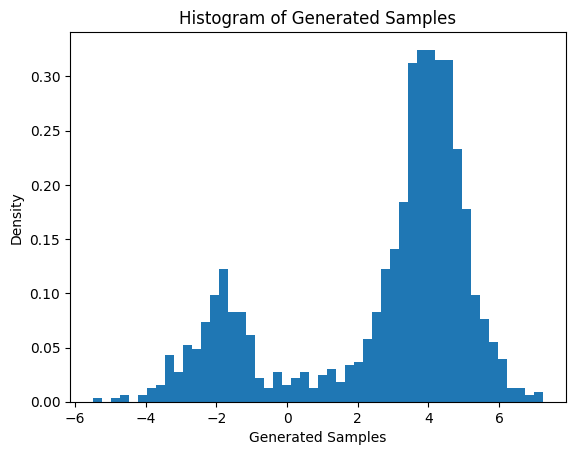

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load generated samples
generated_samples = []
for epoch in range(0, n_epochs, 10):
    samples = np.load(f"samples/epoch_{epoch}.npy")
    generated_samples.extend(samples)

generated_samples = np.concatenate(generated_samples)



# Plot histogram
plt.hist(generated_samples, bins=50, density=True)
plt.xlabel("Generated Samples")
plt.ylabel("Density")
plt.title("Histogram of Generated Samples")
plt.show()


#**Implementing to sampling from 2D Gaussian**


In [ ]:
import argparse
import os
import numpy as np
import math
import torch

import torch.nn as nn
import torch.nn.functional as F

os.makedirs("samples", exist_ok=True)

n_dimensions = 2
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
sample_interval = 400

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, n_dimensions)
        )

    def forward(self, z):
        x = self.model(z)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(n_dimensions, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        validity = self.model(x)
        return validity


class Bimodal_ND():
  # sample from a multivariate bimodal mixture of gaussians
  def __init__(self, m1, s1, m2, s2, w1, n_dim):
    self.m1 = m1
    self.m2 = m2
    self.s1 = s1
    self.s2 = s2
    self.w1 = w1
    self.n_dim = n_dim

  def sample(self, n_samples):
    mode = np.random.choice([0, 1], size=n_samples, p=[self.w1, 1 - self.w1])
    samples1 = np.random.multivariate_normal(self.m1, self.s1, size=np.sum(mode == 0))
    samples2 = np.random.multivariate_normal(self.m2, self.s2, size=np.sum(mode == 1))

    samples = np.concatenate([samples1, samples2])
    samples = np.reshape(samples, (n_samples, self.n_dim))

    return samples


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor



# ----------
#  Training
# ----------

m1 = np.array([2,2])
s1 = np.array([[1,0],[0,1]])
m2 = np.array([-2,-2])
s2 = np.array([[1,0],[0,1]])
w1 = 0.5

# # of iterations per epoch
num_iters = 200


distr = Bimodal_ND(m1, s1, m2, s2, w1, n_dimensions)


for epoch in range(n_epochs):
    for i in range(num_iters):

        # Adversarial ground truths
        valid = Variable(Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))

        # Generate a batch of samples
        gen_samples = generator(z)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to distinguish real samples)

        data = distr.sample(batch_size)

        real_samples = Variable(Tensor(data))
        real_loss = adversarial_loss(discriminator(real_samples), valid)

        # Measure discriminator's ability to distinguish generated samples
        fake_loss = adversarial_loss(discriminator(gen_samples.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_samples), valid)

        g_loss.backward()
        optimizer_G.step()

        if i % num_iters == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, num_iters, d_loss.item(), g_loss.item())
            )

    # Generate and save samples
    if epoch % 10 == 0:
        with torch.no_grad():
            z = Variable(Tensor(np.random.normal(0, 1, (batch_size, latent_dim))))
            gen_samples = generator(z)
            np.save(f"samples/epoch_{epoch}.npy", gen_samples.cpu().numpy())


[Epoch 0/200] [Batch 0/200] [D loss: 0.657999] [G loss: 0.631571]
[Epoch 1/200] [Batch 0/200] [D loss: 0.652094] [G loss: 1.142488]
[Epoch 2/200] [Batch 0/200] [D loss: 0.621630] [G loss: 1.074748]
[Epoch 3/200] [Batch 0/200] [D loss: 0.500049] [G loss: 1.013386]
[Epoch 4/200] [Batch 0/200] [D loss: 0.652495] [G loss: 0.752813]
[Epoch 5/200] [Batch 0/200] [D loss: 0.640955] [G loss: 0.813864]
[Epoch 6/200] [Batch 0/200] [D loss: 0.645561] [G loss: 0.766172]
[Epoch 7/200] [Batch 0/200] [D loss: 0.642585] [G loss: 0.817470]
[Epoch 8/200] [Batch 0/200] [D loss: 0.658210] [G loss: 0.818089]
[Epoch 9/200] [Batch 0/200] [D loss: 0.640370] [G loss: 0.834077]
[Epoch 10/200] [Batch 0/200] [D loss: 0.653714] [G loss: 0.838459]
[Epoch 11/200] [Batch 0/200] [D loss: 0.712069] [G loss: 0.728581]
[Epoch 12/200] [Batch 0/200] [D loss: 0.702179] [G loss: 0.756484]
[Epoch 13/200] [Batch 0/200] [D loss: 0.680702] [G loss: 0.732418]
[Epoch 14/200] [Batch 0/200] [D loss: 0.699864] [G loss: 0.689912]
[Epoc

#**Visualizing 2D Bimodal**

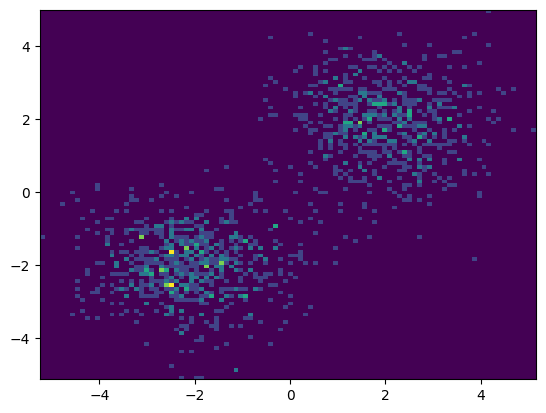

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

generated_samples = []
for epoch in range(0, n_epochs, 10):
    samples = np.load(f"samples/epoch_{epoch}.npy")
    generated_samples.append(samples)

final = np.concatenate(generated_samples)

plt.hist2d(final[:, 0], final[:, 1], bins = 100)
plt.show()

/bin/bash: nvidia-smi: command not found
